In [1]:
import pandas as pd
import numpy as np
import gc
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import os
import joblib
import random
import math
from tqdm import tqdm 

from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import argrelmax

from math import pi, sqrt, exp
import sklearn,sklearn.model_selection
from sklearn.metrics import mean_squared_error
import torch
from torch import nn,Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")

from transformers import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModel

from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import ctypes
torch.set_num_interop_threads(4)
torch.set_num_threads(4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Fundamental config
WORKERS = os.cpu_count()//2
N_FOLDS = 1

SIGMA = 720 #average length of day is 24*60*12 = 17280 for comparison
SAMPLE_FREQ = 12 # 1 obs per minute
MAX_LEN = (24*60*12) # 1day per chunk
MAX_CHUNK_LEN = MAX_LEN // SAMPLE_FREQ # 1440pts = 1day

In [3]:
class PATHS:
    MAIN_DIR = "/kaggle/input/child-mind-institute-detect-sleep-states/"
    # CSV FILES : 
    SUBMISSION = MAIN_DIR + "sample_submission.csv"
    TRAIN_EVENTS = MAIN_DIR + "train_events.csv"
    # PARQUET FILES:
    TRAIN_SERIES = MAIN_DIR + "train_series.parquet"
    TEST_SERIES = MAIN_DIR + "test_series.parquet"
class CFG:
    DEMO_MODE = True
class data_reader:
    def __init__(self, demo_mode):
        super().__init__()
        # MAPPING FOR DATA LOADING :
        self.names_mapping = {
            "submission" : {"path" : PATHS.SUBMISSION, "is_parquet" : False, "has_timestamp" : False}, 
            "train_events" : {"path" : PATHS.TRAIN_EVENTS, "is_parquet" : False, "has_timestamp" : True},
            "train_series" : {"path" : PATHS.TRAIN_SERIES, "is_parquet" : True, "has_timestamp" : True},
            "test_series" : {"path" : PATHS.TEST_SERIES, "is_parquet" : True, "has_timestamp" : True}
        }
        self.valid_names = ["submission", "train_events", "train_series", "test_series"]
        self.demo_mode = demo_mode
    
    def verify(self, data_name):
        "function for data name verification"
        if data_name not in self.valid_names:
            print("PLEASE ENTER A VALID DATASET NAME, VALID NAMES ARE : ", valid_names)
        return
    
    def cleaning(self, data):
        "cleaning function : drop na values"
        before_cleaning = len(data)
        print("Number of missing timestamps : ", len(data[data["timestamp"].isna()]))
        data = data.dropna(subset=["timestamp"])
        after_cleaning = len(data)
        print("Percentage of removed rows : {:.1f}%".format(100 * (before_cleaning - after_cleaning) / before_cleaning) )
#         print(data.isna().any())
#         data = data.bfill()
        return data
    
    @staticmethod
    def reduce_memory_usage(data):
        "iterate through all the columns of a dataframe and modify the data type to reduce memory usage."
        start_mem = data.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        for col in data.columns:
            col_type = data[col].dtype    
            if col_type != object:
                c_min = data[col].min()
                c_max = data[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        data[col] = data[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        data[col] = data[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        data[col] = data[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        data[col] = data[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        data[col] = data[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        data[col] = data[col].astype(np.float32)
                    else:
                        data[col] = data[col].astype(np.float64)
            else:
                data[col] = data[col].astype('category')

        end_mem = data.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        return data
    
    def load_data(self, data_name):
        "function for data loading"
        self.verify(data_name)
        data_props = self.names_mapping[data_name]
        if data_props["is_parquet"]:
            if self.demo_mode:
                pf = ParquetFile(data_props["path"]) 
                demo_rows = next(pf.iter_batches(batch_size=20_000)) 
                data = pa.Table.from_batches([demo_rows]).to_pandas()
            else:
                data = pd.read_parquet(data_props["path"])
        else:
            if self.demo_mode:
                data = pd.read_csv(data_props["path"], nrows=20_000)
            else:
                data = pd.read_csv(data_props["path"])
                
        gc.collect()
        if data_props["has_timestamp"]:
            print('cleaning')
            data = self.cleaning(data)
            gc.collect()
        #data = self.reduce_memory_usage(data)
        return data

In [4]:
reader = data_reader(demo_mode=False)
test_series = reader.load_data(data_name="test_series")
ids = test_series.series_id.unique()
gc.collect()

cleaning
Number of missing timestamps :  0
Percentage of removed rows : 0.0%


0

In [5]:
class US_BLK(nn.Module):
    def __init__(self, in_c, out_c, in_len, ks=7, dilation=1, us_factor=2):
        super().__init__()
        padding = ((ks-1)*dilation)//2
        self.us = nn.Upsample(scale_factor=us_factor, mode='linear')
        self.conv1 = nn.Conv1d(in_c, out_c, ks, padding=padding, dilation=dilation)
        self.ln1 = nn.LayerNorm([out_c, in_len])
        self.act1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv1d(out_c, out_c, ks, padding=padding, dilation=dilation)
        self.ln2 = nn.LayerNorm([out_c, in_len])
        self.act2 = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.us(x)
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x = self.act2(x)
        return x
        
class BertEncoder(torch.nn.Module):
    
    def __init__(self, conf, in_c=2, out_c=2, emb_dim=8, pretrained=True, base=96):
        super().__init__()
        
        self.config = conf
        
        self.bert = AutoModel.from_config(self.config)
            
        self.bert = self.bert.encoder
        
        self.fc_in = nn.Linear(in_c, self.config.hidden_size-emb_dim)
        self.hr_emb = nn.Embedding(24, emb_dim)

        self.upsample_blocks = nn.ModuleList([])
        self.upsample_blocks.append(US_BLK(self.config.hidden_size, base*4, MAX_LEN//(2*2), us_factor=3))
        self.upsample_blocks.append(US_BLK(base*4, base*2, MAX_LEN//2, us_factor=2))
        self.upsample_blocks.append(US_BLK(base*2, base, MAX_LEN, us_factor=2))
        
        self.fc_out = nn.Linear(base, out_c)

    def forward(self, x, t, att_mask=None):
        x = self.fc_in(x)        
        t = self.hr_emb(t)
        x = torch.cat([x, t.squeeze(2)], dim=-1)

        if att_mask is None:
            att_mask = torch.ones(x.size()[:2]).to(x.device)
        
        bert_output = self.bert(x, attention_mask=att_mask)
        x = bert_output.last_hidden_state

        x = x.permute(0,2,1)

        for b in self.upsample_blocks:
            x = b(x)

        x = x.permute(0,2,1)
        
        scores = self.fc_out(x) 
        
        return scores

In [6]:
class SleepTestDataset(Dataset):
    def __init__(
        self,
        test_series,
        test_ids
    ):
        self.enmo_mean = np.load('/kaggle/input/detect-sleep-states-dataprepare/enmo_mean.npy')
        self.enmo_std = np.load('/kaggle/input/detect-sleep-states-dataprepare/enmo_std.npy')

        self.Xs = self.conv_dfs(test_series, test_ids)
        
        self.feat_list = np.load('/kaggle/input/cmi-dss-debertav3-public/feature_list.npy')
        self.label_list = ['onset', 'wakeup']
        
        self.hour_feat= ['hour']
        
            
    def conv_dfs(self, series, ids):
        res = []
        for j, viz_id in tqdm(enumerate(ids), total=len(ids)):
            viz_series = series.loc[(series.series_id==viz_id)].copy().reset_index()
            viz_series['dt'] = pd.to_datetime(viz_series.timestamp,format = '%Y-%m-%dT%H:%M:%S%z').astype("datetime64[ns, UTC-04:00]")
            viz_series['hour'] = viz_series['dt'].dt.hour
            new_df = viz_series[['step', 'anglez', 'enmo', 'hour']]
            res.append(new_df)

        return res
    

    def norm_feat_eng(self, X, init=False):
        X['anglez'] = X['anglez'] / 90.0
        X['enmo'] = (X['enmo'] - self.enmo_mean)/ (self.enmo_std + 1e-12)
        
        for w in [1, 2, 4, 8, 16]:    
            X['anglez_shift_pos_' + str(w)] = X['anglez'].shift(w).fillna(0)
            X['anglez_shift_neg_' + str(w)] = X['anglez'].shift(-w).fillna(0)
            
            X['enmo_shift_pos_' + str(w)] = X['enmo'].shift(w).fillna(0)
            X['enmo_shift_neg_' + str(w)] = X['enmo'].shift(-w).fillna(0)
            
            if init:
                self.feat_list.append('anglez_shift_pos_' + str(w))
                self.feat_list.append('anglez_shift_neg_' + str(w))
                
                self.feat_list.append('enmo_shift_pos_' + str(w))
                self.feat_list.append('enmo_shift_neg_' + str(w))
            
        for r in [17, 33, 65]:
            tmp_anglez = X['anglez'].rolling(r, center=True)
            X[f'anglez_mean_{r}'] = tmp_anglez.mean()
            X[f'anglez_std_{r}'] = tmp_anglez.std()            
            
            tmp_enmo = X['enmo'].rolling(r, center=True)
            X[f'enmo_mean_{r}'] = tmp_enmo.mean()
            X[f'enmo_std_{r}'] = tmp_enmo.std()
            
            if init:
                self.feat_list.append(f'anglez_mean_{r}')
                self.feat_list.append(f'anglez_std_{r}')

                self.feat_list.append(f'enmo_mean_{r}')
                self.feat_list.append(f'enmo_std_{r}')
                
        X = X.fillna(0)
        
        return X.astype(np.float32)

    def gauss(self,n=SIGMA,sigma=SIGMA*0.15):
        # guassian distribution function
        r = range(-int(n/2),int(n/2)+1)
        return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]
    
    def __len__(self):
        return len(self.Xs)
    
    def compress(self, xt, method='mean', sample_freq=SAMPLE_FREQ):
        x, t = xt
        seq_len = x.shape[0]
        if method == 'mean':
            x = x.reshape(seq_len//sample_freq, sample_freq, -1).mean(1)
            t = t.reshape(seq_len//sample_freq, sample_freq, 1).mean(1)
            
        else:
            raise NotImplementedError()

        
        return x.astype(np.float32), t.astype(np.int32)

    def __getitem__(self, index):
        X = self.Xs[index].copy()
        X = self.norm_feat_eng(X, init=False)
        x = X[self.feat_list].values.astype(np.float32)     
        t = X[self.hour_feat].values.astype(np.int32)
        
        if len(X)%SAMPLE_FREQ!=0:
            res = SAMPLE_FREQ - (len(X)%SAMPLE_FREQ)
            x = np.pad(x, ((0, res), (0, 0)))
            t = np.pad(t, ((0, res), (0, 0)))
            
        x, t = self.compress((x, t), method='mean')
                
        return x, t

test_ds = SleepTestDataset(test_series, ids)

100%|██████████| 3/3 [00:00<00:00, 106.30it/s]


In [7]:
# class SleepDataset(Dataset):
#     def __init__(
#         self,
#         folder,
#         max_len=17280,
#         is_train=False,
#         sample_per_epoch=10000
#     ):
#         self.enmo_mean = np.load('/kaggle/input/detect-sleep-states-dataprepare/enmo_mean.npy')
#         self.enmo_std = np.load('/kaggle/input/detect-sleep-states-dataprepare/enmo_std.npy')
        
#         self.max_len = max_len
#         assert max_len % SAMPLE_FREQ == 0
        
#         self.is_train = is_train
        
#         self.max_df_size = 0
#         self.min_df_size = 1e9
        
#         self.sample_per_epoch = sample_per_epoch
        
#         self.feat_list = ['anglez','enmo']
        
#         self.Xys = self.read_csvs(folder)        
        
#         self.label_list = ['onset', 'wakeup']
        
#         self.hour_feat= ['hour']
        
#         self.compress_methods = ['mean', 'median', 'fixed']
        
#     def read_csvs(self, folder):
#         res = []
#         if type(folder) is str:
#             files = glob.glob(f'{folder}/*.csv')
#         else:
#             files = folder
#         for i, f in tqdm(enumerate(files), total=len(files), leave=False):
#             df = pd.read_csv(f)
#             df = self.norm_feat_eng(df, init=True if i==0 else False)
                
#             res.append(df)
#             self.max_df_size = max(self.max_df_size, len(df))
#             self.min_df_size = min(self.min_df_size, len(df))
#         return res
    
#     def compress(self, xt, method='mean', sample_freq=SAMPLE_FREQ):
#         x, t = xt
#         seq_len = x.shape[0]
#         if method == 'mean':
#             x = x.reshape(seq_len//sample_freq, sample_freq, -1).mean(1)
#             t = t.reshape(seq_len//sample_freq, sample_freq, 1).mean(1)
            
#         if method == 'median':
#             x = np.median(x.reshape(seq_len//sample_freq, sample_freq, -1), axis=1)
#             t = np.median(t.reshape(seq_len//sample_freq, sample_freq, 1), axis=1)
            
#         if method == 'fixed':
#             start = torch.randint(0, sample_freq, size=(1,))[0].numpy()
#             x = x[start::sample_freq]
#             t = t[start::sample_freq]
        
#         return x.astype(np.float32), t.astype(np.int32)

#     def norm_feat_eng(self, X, init=False):
#         X['anglez'] = X['anglez'] / 90.0
#         X['enmo'] = (X['enmo'] - self.enmo_mean) / (self.enmo_std + 1e-12)
        
#         for w in [1, 2, 4, 8, 16]:    
#             X['anglez_shift_pos_' + str(w)] = X['anglez'].shift(w).fillna(0)
#             X['anglez_shift_neg_' + str(w)] = X['anglez'].shift(-w).fillna(0)
            
#             X['enmo_shift_pos_' + str(w)] = X['enmo'].shift(w).fillna(0)
#             X['enmo_shift_neg_' + str(w)] = X['enmo'].shift(-w).fillna(0)
            
#             if init:
#                 self.feat_list.append('anglez_shift_pos_' + str(w))
#                 self.feat_list.append('anglez_shift_neg_' + str(w))
                
#                 self.feat_list.append('enmo_shift_pos_' + str(w))
#                 self.feat_list.append('enmo_shift_neg_' + str(w))
            
#         for r in [17, 33, 65]:
#             tmp_anglez = X['anglez'].rolling(r, center=True)
#             X[f'anglez_mean_{r}'] = tmp_anglez.mean()
#             X[f'anglez_std_{r}'] = tmp_anglez.std()            
            
#             tmp_enmo = X['enmo'].rolling(r, center=True)
#             X[f'enmo_mean_{r}'] = tmp_enmo.mean()
#             X[f'enmo_std_{r}'] = tmp_enmo.std()
            
#             if init:
#                 self.feat_list.append(f'anglez_mean_{r}')
#                 self.feat_list.append(f'anglez_std_{r}')

#                 self.feat_list.append(f'enmo_mean_{r}')
#                 self.feat_list.append(f'enmo_std_{r}')
                
#         X = X.fillna(0)
        
#         return X.astype(np.float32)

#     def gauss(self, n=SIGMA, sigma=SIGMA*0.15):
#         # guassian distribution function
#         r = range(-int(n/2),int(n/2)+1)
#         return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]
    
#     def __len__(self):
#         return self.sample_per_epoch if self.is_train else len(self.Xys)

#     def __getitem__(self, index):
#         Xy = self.Xys[index].copy()
#         X = Xy[self.feat_list].values.astype(np.float32)     
#         t = Xy[self.hour_feat].values.astype(np.int32)

#         if len(Xy)%SAMPLE_FREQ!=0:
#             res = SAMPLE_FREQ - (len(Xy)%SAMPLE_FREQ)
#             X = np.pad(X, ((0, res), (0, 0)))
#             t = np.pad(t, ((0, res), (0, 0)))

#         X, t = self.compress((X, t), method='mean')

#         return X, t

# import glob
# valid_fpaths = sorted(glob.glob(f"/kaggle/input/detect-sleep-states-dataprepare/train_csvs/*.csv"))
# test_ds = SleepDataset(valid_fpaths, is_train=False)

In [8]:
test_ds[0][0].shape

(13, 34)

In [9]:
if len(test_ds.Xs)==3:
    for x in test_ds.Xs:
        display(x)

,step,anglez,enmo,hour
0,0,2.636700,0.0217,15
1,1,2.636800,0.0215,15
2,2,2.637000,0.0216,15
3,3,2.636800,0.0213,15
4,4,2.636800,0.0215,15
...,...,...,...,...
145,145,-79.990601,0.0135,15
146,146,-80.028999,0.0136,15
147,147,-80.009300,0.0137,15
148,148,-80.066902,0.0135,15


,step,anglez,enmo,hour
0,0,38.892899,0.0803,12
1,1,29.374399,0.0752,12
2,2,37.225101,0.1791,12
3,3,46.937000,0.0922,12
4,4,60.486698,0.0342,12
...,...,...,...,...
145,145,-88.216599,0.0000,12
146,146,-88.216599,0.0000,12
147,147,-88.216599,0.0000,12
148,148,-88.216599,0.0000,12


,step,anglez,enmo,hour
0,0,-77.314903,0.0868,13
1,1,-52.183800,0.0434,13
2,2,-53.218601,0.0541,13
3,3,-51.541698,0.0612,13
4,4,-24.637300,0.0591,13
...,...,...,...,...
145,145,-59.696899,0.0601,13
146,146,-35.656601,0.0427,13
147,147,-21.582399,0.0309,13
148,148,-42.616001,0.0328,13


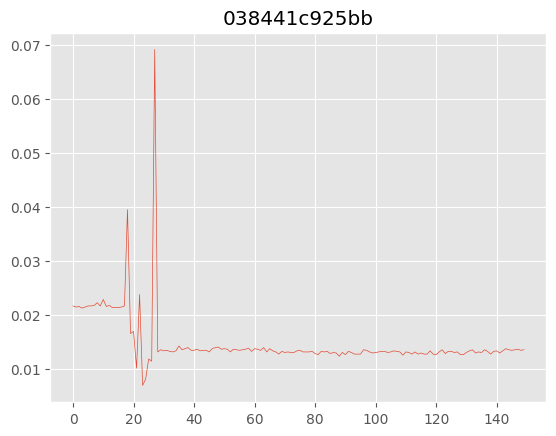

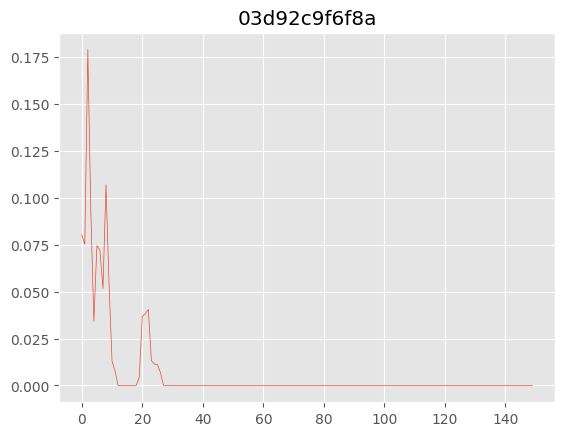

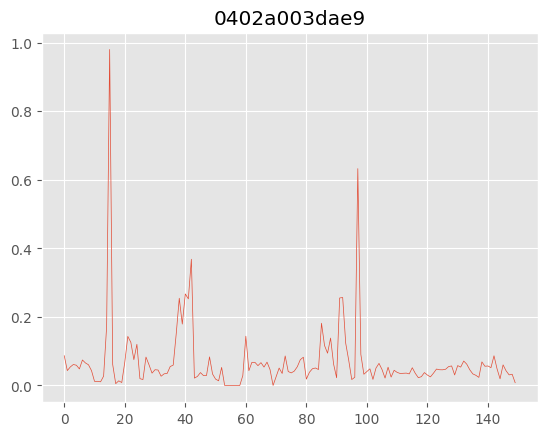

In [10]:
if len(test_ds.Xs)==3:
    for i, x in enumerate(test_ds.Xs):
        plt.plot(x['enmo'], lw=0.5)
        plt.title(ids[i])
        plt.show()

In [11]:
del test_series, reader
gc.collect()

7423

In [12]:
# Model config
EMB_DIM = 34
MODEL_NAME = 'smallbenchnlp/roberta-small'
CONF_PATH = '/kaggle/input/roberta-small/roberta-small_config.pth'

In [13]:
test_dl = DataLoader(
    test_ds,
    batch_size=1,
    pin_memory=True,
    num_workers=WORKERS,
    shuffle=False,
    drop_last=False
)

In [14]:
conf = torch.load(CONF_PATH)

In [15]:
autocast = torch.cuda.amp.autocast(enabled=True, dtype=torch.half)
scaler = torch.cuda.amp.GradScaler(enabled=True, init_scale=4096)

In [16]:
def lpf(wave, fs=12*60*24, fe=60, n=3):
    nyq = fs / 2.0
    b, a = signal.butter(1, fe/nyq, btype='low')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave

In [17]:
def padding_(x, tgt_len=MAX_CHUNK_LEN):
    res = tgt_len - (x.size(-2) % tgt_len)
    x = F.pad(x, (0, 0, 0, res))
    return x

In [18]:
submission = pd.DataFrame()

In [19]:
y_preds = []
for fold in range(N_FOLDS):
    MODEL_PATH = f'/kaggle/input/roberta-small/roberta.pth'
    model = BertEncoder(
        conf=conf, 
        in_c=len(test_ds.feat_list), 
        out_c=2, 
        emb_dim=EMB_DIM, 
        pretrained=False,
    ).to(device)

    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval().half()
    with torch.no_grad():
        with tqdm(test_dl, leave=True) as pbar:
            for j, (X_batch, hr_batch) in enumerate(pbar):
                X_batch = X_batch.to(device)
                hr_batch = hr_batch.to(device)
                
                x_seq_len = X_batch.shape[1]
                y_pred = torch.zeros((1, x_seq_len*SAMPLE_FREQ, 2)).to(device)
                y_seq_len = y_pred.shape[1]
                
                if x_seq_len%MAX_CHUNK_LEN != 0:
                    X_batch = padding_(X_batch, MAX_CHUNK_LEN)
                    hr_batch = padding_(hr_batch, MAX_CHUNK_LEN)

                if y_seq_len%MAX_LEN != 0:
                    y_pred = padding_(y_pred, MAX_LEN)

                YPOS = 0
                for i in range(0, x_seq_len, MAX_CHUNK_LEN):
                    X_chunk = X_batch[:, i : i + MAX_CHUNK_LEN]
                    hr_chunk = hr_batch[:, i : i + MAX_CHUNK_LEN]
                    with autocast:
                        p = model(X_chunk, hr_chunk)
                        y_pred[:, YPOS : YPOS + MAX_CHUNK_LEN*SAMPLE_FREQ] = p

                    YPOS += MAX_CHUNK_LEN*SAMPLE_FREQ

                y_pred = y_pred[:, :y_seq_len]
                    
                if len(test_dl)==3:
                    print(X_batch.sum(), X_batch.sum(), y_pred.sum())

                if fold==0:
                    y_preds.append(y_pred[0].sigmoid().cpu().numpy().astype(np.float32) / N_FOLDS)
                else:
                    y_preds[j] += y_pred[0].sigmoid().cpu().numpy().astype(np.float32) / N_FOLDS
                        
                
                del X_batch, hr_batch
                gc.collect()
                torch.cuda.empty_cache()

    del model
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/3 [00:00<?, ?it/s]

tensor(-152.1145, device='cuda:0') tensor(-152.1145, device='cuda:0') tensor(-998.7871, device='cuda:0')


 33%|███▎      | 1/3 [00:04<00:09,  4.91s/it]

tensor(-195.3471, device='cuda:0') tensor(-195.3471, device='cuda:0') tensor(-980.7793, device='cuda:0')


 67%|██████▋   | 2/3 [00:05<00:02,  2.22s/it]

tensor(24.2219, device='cuda:0') tensor(24.2219, device='cuda:0') tensor(-987.7734, device='cuda:0')


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

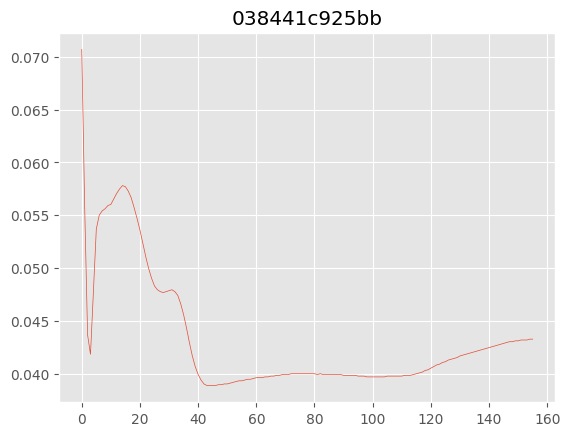

 33%|███▎      | 1/3 [00:00<00:00,  3.39it/s]

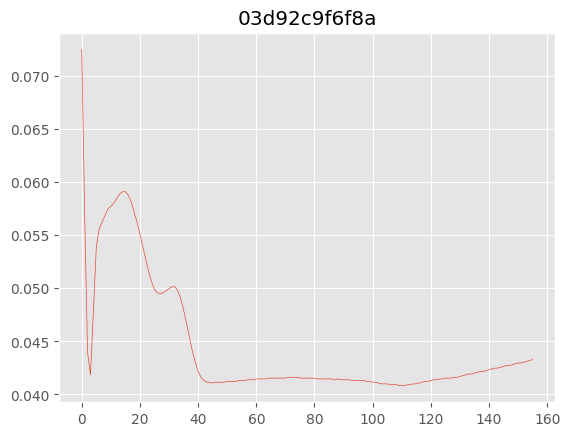

 67%|██████▋   | 2/3 [00:00<00:00,  3.44it/s]

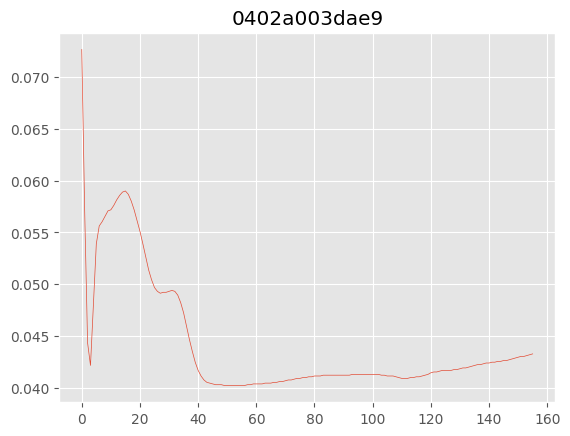

100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


In [20]:
for i, y_pred in tqdm(enumerate(y_preds), total=len(y_preds)):
    before_RMSE = np.sqrt(mean_squared_error(y_pred, np.zeros_like(y_pred)))

    if len(test_ds.Xs)!=3:
        y_pred[:,0] = lpf(y_pred[:,0])
        y_pred[:,1] = lpf(y_pred[:,1])
        
    else:

        plt.plot(y_pred[:,0], lw=0.5)
        plt.title(ids[i])
        plt.show()

    after_RMSE = np.sqrt(mean_squared_error(y_pred, np.zeros_like(y_pred)))

    decay_ratio = before_RMSE/after_RMSE
    y_pred *= decay_ratio

    onset_candi = argrelmax(y_pred[:, 0], order=12*60*6) # 12*60*6 = 6hours
    wakeup_candi = argrelmax(y_pred[:, 1], order=12*60*6) # 12*60*6 = 6hours


    series_id = ids[i]
    try:                
        onset_candi = onset_candi[0]
        onset = pd.DataFrame({'series_id': [series_id]*len(onset_candi),
                             'step': onset_candi,
                             'score': y_pred[onset_candi, 0].reshape(-1),
                             'event': ['onset']*len(onset_candi)})
    except:
         onset = pd.DataFrame()

    try:
        wakeup_candi = wakeup_candi[0]
        wakeup = pd.DataFrame({'series_id': [series_id]*len(wakeup_candi),
                             'step': wakeup_candi,
                             'score': y_pred[wakeup_candi, 1].reshape(-1),
                             'event': ['wakeup']*len(wakeup_candi)})
    except:
        wakeup = pd.DataFrame()

    submission = pd.concat([submission, onset, wakeup], axis=0)

gc.collect()
torch.cuda.empty_cache()

In [21]:
submission = submission.sort_values(['series_id','step']).reset_index(drop=True)
submission['row_id'] = submission.index.astype(int)
submission['score'] = submission['score'].fillna(submission['score'].mean())
submission = submission[['row_id','series_id','step','event','score']]
submission['step'] = submission['step']
submission.to_csv('submission.csv',index=False)

In [22]:
submission

,row_id,series_id,step,event,score
